In [1]:
import os
os.chdir("../")

In [2]:
import warnings
import numpy as np
import jax.numpy as jnp
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


import matplotlib.font_manager
font_path = "/home/nanxi/.local/share/fonts/Palatino-Linotype-Regular.ttf"
if os.path.exists(font_path):
    matplotlib.font_manager.fontManager.addfont(font_path)
    prop = matplotlib.font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Set font to {prop.get_name()}")

Set font to Palatino Linotype


In [3]:
direction = "./data/FS-132-1_direct.txt"
direction = np.loadtxt(direction, max_rows=3600*200, dtype=str)
direction = direction[:, -1].astype(np.float32)
speed = "./data/FS-132-1_speed.txt"
speed = np.loadtxt(speed, max_rows=3600*200, dtype=str)
speed = speed[:, -1].astype(np.float32)

fs = 1/2
decimation_factor = int(100 / fs)
speed = signal.decimate(speed, decimation_factor, ftype='fir',)
direction = signal.decimate(direction, decimation_factor, ftype='fir',)

ux = speed * np.cos(np.deg2rad(direction))
uy = speed * np.sin(np.deg2rad(direction))
u_bar = np.sqrt(np.mean(ux**2) + np.mean(uy**2))
beta_bar = np.arctan2(np.mean(uy), np.mean(ux))  # radians

uu = ux * np.cos(beta_bar) + uy * np.sin(beta_bar) - u_bar

from scipy.signal import medfilt
uu = medfilt(uu, kernel_size=3) 
# plt.plot(wind_data+u_bar)

In [4]:
# # load mat data
# from scipy.io import loadmat
# from scipy import signal
# data = loadmat("./data/high_rise_building_wind.mat")
# wind_data = data["windsp_1h"].flatten()
# fs = 0.5
# decimation_factor = int(100 / fs)
# wind_data = signal.decimate(wind_data, decimation_factor, ftype='fir',)


In [5]:
frequencies, psd = signal.welch(uu, fs=fs,
                                window='hamming', 
                                scaling='density', nperseg=1024)
frequencies = frequencies[1:]  # 去掉直流分量
psd = psd[1:]
u10 = u_bar * (10 / 450) ** 0.30
z = 632
z0 = 1.0
H_ = 200
K = 0.4
zd = H_ - z0 / K
u_star = K * u_bar / np.log((z - zd) / z0)
f = frequencies * z / u_bar
reference_psd = 200 * f / (1 + 50 * f)**(5/3) * u_star**2 / frequencies

In [6]:
u_bar, u10

(np.float32(10.2651615), np.float32(3.2764387))

In [7]:
frequencies

array([0.00048828, 0.00097656, 0.00146484, 0.00195312, 0.00244141,
       0.00292969, 0.00341797, 0.00390625, 0.00439453, 0.00488281,
       0.00537109, 0.00585938, 0.00634766, 0.00683594, 0.00732422,
       0.0078125 , 0.00830078, 0.00878906, 0.00927734, 0.00976562,
       0.01025391, 0.01074219, 0.01123047, 0.01171875, 0.01220703,
       0.01269531, 0.01318359, 0.01367188, 0.01416016, 0.01464844,
       0.01513672, 0.015625  , 0.01611328, 0.01660156, 0.01708984,
       0.01757812, 0.01806641, 0.01855469, 0.01904297, 0.01953125,
       0.02001953, 0.02050781, 0.02099609, 0.02148438, 0.02197266,
       0.02246094, 0.02294922, 0.0234375 , 0.02392578, 0.02441406,
       0.02490234, 0.02539062, 0.02587891, 0.02636719, 0.02685547,
       0.02734375, 0.02783203, 0.02832031, 0.02880859, 0.02929688,
       0.02978516, 0.03027344, 0.03076172, 0.03125   , 0.03173828,
       0.03222656, 0.03271484, 0.03320312, 0.03369141, 0.03417969,
       0.03466797, 0.03515625, 0.03564453, 0.03613281, 0.03662

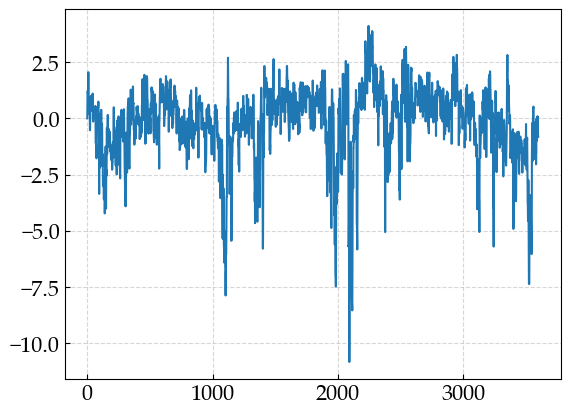

In [8]:
plt.plot(uu)

Fitted parameters: [9.17628749 1.21301218 2.45531768]


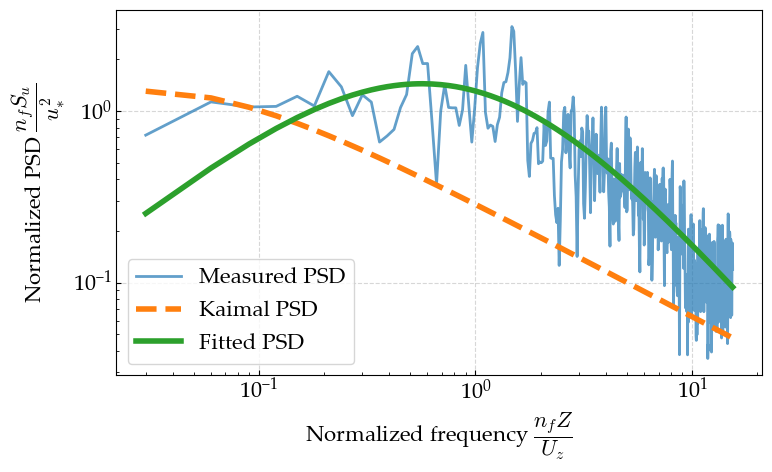

In [10]:
from scipy.optimize import curve_fit

normed_f = frequencies * z / u_bar
normed_psd = psd * frequencies / u_star**2

def func(f, a, b,c):
    return a * f / (1 + b * f)**(c)

popt, pcov = curve_fit(func, normed_f, normed_psd,
                       bounds=(0, np.inf), maxfev=10000)
fitted_psd = func(normed_f, *popt)


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies*z/u_bar, psd*frequencies/u_star**2, label="Measured PSD", lw=2, alpha=0.7,)
ax.loglog(frequencies*z/u_bar, reference_psd*frequencies/u_star**2, label="Kaimal PSD", lw=4,  ls="--")
ax.loglog(normed_f, fitted_psd, label="Fitted PSD", lw=4, )
ax.legend(loc="lower left",)
x_notation = r"$\dfrac{n_fZ}{U_z}$"
y_notation = r"$\dfrac{n_fS_u}{u_{*}^2}$"
ax.set_xlabel("Normalized frequency " + x_notation,)
ax.set_ylabel("Normalized PSD " + y_notation,)
fig.tight_layout()
# fig.savefig("./img/building_wind_fitted_psd.png", dpi=300, bbox_inches="tight")
# fig.savefig("./img/building_wind_fitted_psd.pdf", bbox_inches="tight")

print("Fitted parameters:", popt, )
a, b, c = popt

In [10]:
from stochastic_wind_simulate.jax_backend.psd import WindSpectrumNonDimensional

class CustomSpectrum(WindSpectrumNonDimensional):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def calculate_power_spectrum_u(self, n, u_star, f):
        """Calculate along-wind fluctuating wind power spectral density S_u(n)."""
        return (u_star**2 / n) * (a * f / ((1 + b * f) ** (c)))

reference_psd = (u_star**2 / frequencies) * (a * normed_f / ((1 + b * normed_f) ** (c)))

In [11]:
from stochastic_wind_simulate import get_simulator, get_visualizer
simulator = get_simulator(backend="jax", key=42, spectrum_type=CustomSpectrum)
T = int(uu.shape[0]/fs)
w_up = fs/2
N = int(T * w_up)
alpha_0 = 0.30
simulator.update_parameters(
    H_bar=H_,
    z_0=z0,
    T=T,
    N=N,
    U_d=u10,
    alpha_0=alpha_0,
    w_up=w_up,
)

n = 100
Z = 632
position = np.zeros((n, 3))
position[:, 2] = np.linspace(232, Z, n)
position[:, 0] = 0
position[:, 1] = 0
wind_speeds = u10 * (jnp.minimum(position[:, 2], 450) / 10) ** alpha_0
samples, frequencies_sim = simulator.simulate_wind(
    position, wind_speeds, component="u"
)
frequencies_sim, psd_sim = signal.welch(samples[-1], fs=fs, window='hamming', 
                                   scaling='density', nperseg=1024)

In [12]:
simulator.params

{'K': 0.4,
 'H_bar': 200,
 'z_0': 1.0,
 'alpha_0': 0.3,
 'C_x': 16.0,
 'C_y': 6.0,
 'C_z': 10.0,
 'w_up': 0.25,
 'N': 1800,
 'z_max': 450.0,
 'U_d': np.float32(3.2764387),
 'M': 3600,
 'T': 7200.0,
 'dt': 2.0,
 'dw': 0.0001388888888888889,
 'z_d': 197.5,
 'backend': 'jax'}

[Text(0.5, 0, 'Frequency (Hz)'),
 Text(0, 0.5, 'Power Spectral Density (m$^2$/s)')]

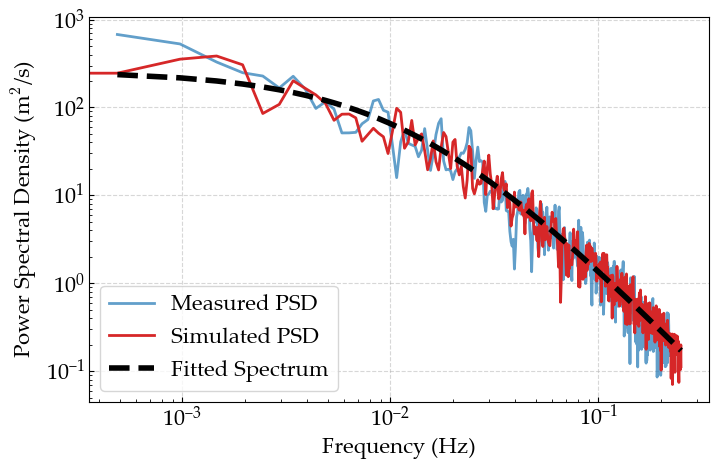

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies[:-60], psd[:-60], label="Measured PSD", color="C0", lw=2, alpha=0.7,)
ax.loglog(frequencies_sim, psd_sim, label="Simulated PSD", color="C3", linestyle="solid", lw=2)
ax.loglog(frequencies, reference_psd, label="Fitted Spectrum", color="black", linestyle="--", lw=4)
ax.legend()
ax.set(xlabel="Frequency (Hz)", ylabel="Power Spectral Density (m$^2$/s)")
# fig.savefig("./img/high_rise_building_wind_spectrum.pdf", bbox_inches="tight")
# fig.savefig("./img/high_rise_building_wind_spectrum.png", bbox_inches="tight", dpi=300)

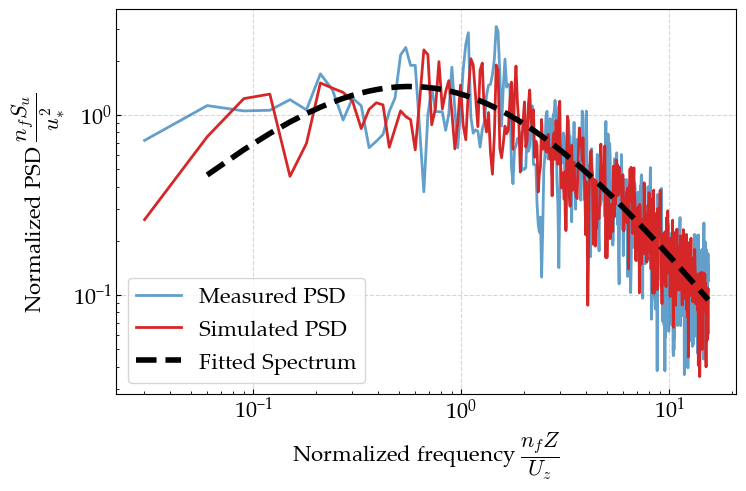

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies*z/u_bar, psd*frequencies/u_star**2, label="Measured PSD", color="C0", lw=2, alpha=0.7,)
ax.loglog(frequencies_sim[1:]*z/u_bar, psd_sim[1:]*frequencies_sim[1:]/u_star**2, label="Simulated PSD", color="C3", linestyle="solid", lw=2)
ax.loglog(frequencies[1:]*z/u_bar, reference_psd[1:]*frequencies[1:]/u_star**2, label="Fitted Spectrum", color="black", linestyle="--", lw=4)
ax.legend()
x_notation = r"$\dfrac{n_fZ}{U_z}$"
y_notation = r"$\dfrac{n_fS_u}{u_{*}^2}$"

ax.set(xlabel="Normalized frequency " + x_notation,
         ylabel="Normalized PSD " + y_notation)
fig.savefig("./img/high_rise_building_wind_spectrum_norm.pdf", bbox_inches="tight")
fig.savefig("./img/high_rise_building_wind_spectrum_norm.png", bbox_inches="tight", dpi=300)

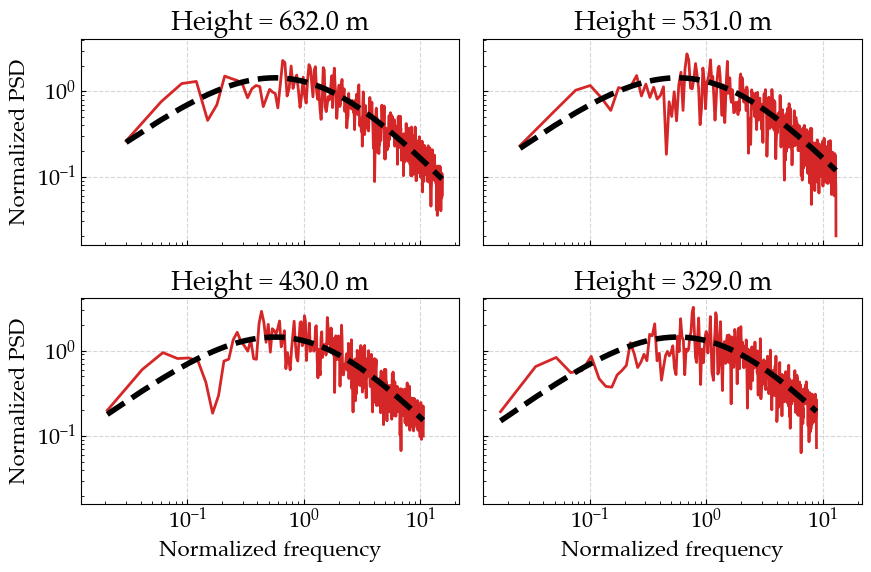

In [15]:
indices = np.arange(100, 0, -25)-1

fig, axes = plt.subplots(2, 2, figsize=(9, 6), sharex=True, sharey=True)
axes = axes.flatten()
for i, idx in enumerate(indices):
    ax = axes[i]
    z = position[idx, 2]
    sample = samples[idx]
    freq, psd = signal.welch(sample, fs=fs, window='hamming', 
                            scaling='density', nperseg=1024)
    freq = freq[1:]
    psd = psd[1:]
    u_bar_z = u10 * (np.minimum(z, 450) / 10) ** alpha_0
    u_star_z = K * u_bar_z / np.log((z - zd) / z0)
    f = freq * z / u_bar_z
    reference_psd = a * f / (1 + b * f)**(c) * u_star_z**2 / freq
    ax.loglog(freq*z/u_bar_z, psd*freq/u_star_z**2, color="C3", linestyle="solid", lw=2)
    ax.loglog(freq*z/u_bar_z, reference_psd*freq/u_star_z**2, label="Kaimal Spectrum", color="black", linestyle="--", lw=4)
    # ax.legend()
    ax.set_title(f"Height = {z:.1f} m")
    if i in [2, 3]:
        ax.set(xlabel="Normalized frequency")
    if i in [0, 2]:
        ax.set(ylabel="Normalized PSD")

fig.tight_layout()

Text(0.5, 0, 'Wind speed (m/s)')

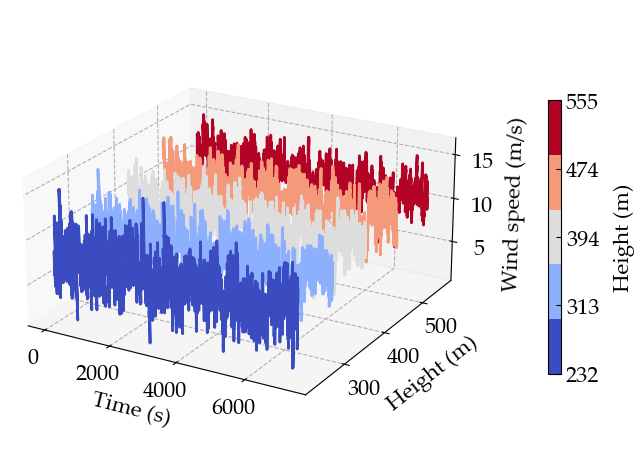

In [16]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'},)
fig.set_constrained_layout(True)
indices = np.arange(0, len(position), len(position) // 5)
times = np.arange(0, simulator.params["M"] * simulator.params["dt"], simulator.params["dt"])

cmap = plt.get_cmap("coolwarm", len(indices))
for i, idx in enumerate(indices):

    uz = wind_speeds[indices[i]]
    data = samples[indices[i]] + uz
    z = position[indices[i], 2]
    z = np.full_like(times, z)
    ax.plot(times, z, data, color=cmap((i)/(len(indices)-1)), 
            label=f"z={z[0]:.1f}m", lw=2, zorder=len(indices)-i)
    
ax_colorbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, pad=0.1, fraction=0.03)
ax_colorbar.set_label("Height (m)", labelpad=10)
# set value of the colorbar ticks
ax_colorbar.set_ticks([(i)/(len(indices)-1) for i in range(len(indices))])
ax_colorbar.set_ticklabels([f"{position[idx, 2]:.0f}" for idx in indices])

ax.set_box_aspect([2,2,1])
ax.view_init(elev=22, azim=300)
ax.set_xlabel("Time (s)", labelpad=10)
ax.set_ylabel("Height (m)", labelpad=10)
ax.set_zlabel("Wind speed (m/s)", labelpad=5)
# 获取当前3D坐标区的位置 [left, bottom, width, height]
# fig.savefig("./img/validate_wind_timehistory_3d.png", dpi=300, bbox_inches='tight')
# fig.savefig("./img/validate_wind_timehistory_3d.pdf", bbox_inches='tight')
# fig.savefig("../wind_simulation_paper/validate_wind_timehistory_3d.pdf", bbox_inches='tight')